# Predict Future Sales

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/overview

Predict total sales for every product and store in the next month.

In this competition i will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

**Goal** - predict total sales for every product and store in the next month.

**Data fields:**
- `ID` - an Id that represents a (Shop, Item) tuple within the test set
- `shop_id` - unique identifier of a shop
- `item_id` - unique identifier of a product
- `item_category_id` - unique identifier of item category
- `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure
- `item_price` - current price of an item
- `date` - date in format dd/mm/yyyy
- `date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- `item_name` - name of item
- `shop_name` - name of shop
- `item_category_name` - name of item category

In [1]:
!pip install catboost --q

     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostRegressor
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("/content/sales_train.csv")
test = pd.read_csv("/content/test.csv")
items = pd.read_csv("/content/items.csv")
shops = pd.read_csv("/content/shops.csv")
item_categories = pd.read_csv("/content/item_categories.csv")
sample_submission = pd.read_csv("/content/sample_submission.csv")

## Getting to know the data.

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
test.isna().sum()


ID         0
shop_id    0
item_id    0
dtype: int64

In [8]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [9]:
items.isna().sum()

item_name           0
item_id             0
item_category_id    0
dtype: int64

In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
shops.isna().sum()

shop_name    0
shop_id      0
dtype: int64

In [12]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
item_categories.isna().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [14]:
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [15]:
sample_submission.isna().sum()

ID                0
item_cnt_month    0
dtype: int64

### Merge data

In [16]:
df = train.merge(items, how='left', on='item_id')
df = df.merge(shops, how='left', on='shop_id')
df = df.merge(item_categories, how='left', on='item_category_id')
# df.drop(['item_id', 'shop_id', 'item_category_id'], axis=1, inplace=True)

In [17]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства


### Data preparation

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           object 
 7   item_category_id    int64  
 8   shop_name           object 
 9   item_category_name  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [19]:
df.isna().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
shop_name             0
item_category_name    0
dtype: int64

Change the data type.

In [20]:
df['date'] = pd.to_datetime(df['date'])

Check duplicates.

In [21]:
df.duplicated().sum()

6

In [22]:
df[df.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name
76962,2013-05-01,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40,"Химки ТЦ ""Мега""",Кино - DVD
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва МТРЦ ""Афи Молл""",Игры - XBOX 360
1671873,2014-01-05,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Тюмень ТЦ ""Гудвин""",Игры - XBOX 360
1866340,2014-12-07,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,"Москва ТРК ""Атриум""",Игры - XBOX 360
2198566,2014-12-31,23,42,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,"СПб ТК ""Невский Центр""",Кино - Blu-Ray


Drop duplicates.

In [23]:
df = df.drop_duplicates()
df.duplicated().sum()

0

## EDA

Look at the shop name.

### Shop name

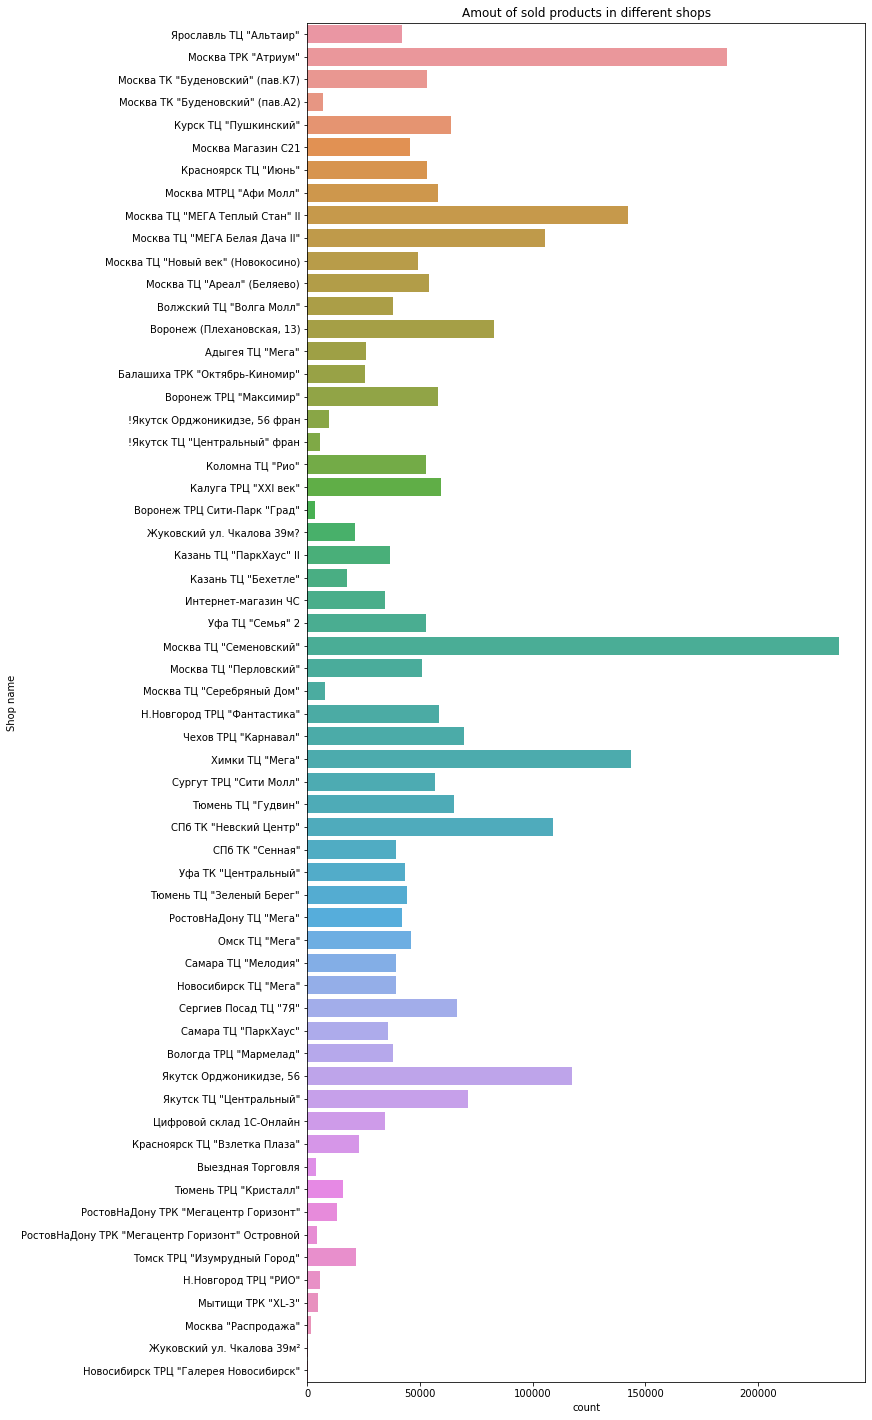

In [24]:
plt.figure(figsize=(10, 25))
sns.countplot(y = df['shop_name'])
plt.ylabel('Shop name')
plt.title('Amout of sold products in different shops')
plt.show()

There are shop in the different cities. Select this cities. 

### Cities

In [25]:
df['city'] = df['shop_name'].apply(lambda x: " ".join(x.split()[:1]))

In [26]:
df['city'].unique()

array(['Ярославль', 'Москва', 'Курск', 'Красноярск', 'Волжский',
       'Воронеж', 'Адыгея', 'Балашиха', '!Якутск', 'Коломна', 'Калуга',
       'Жуковский', 'Казань', 'Интернет-магазин', 'Уфа', 'Н.Новгород',
       'Чехов', 'Химки', 'Сургут', 'Тюмень', 'СПб', 'РостовНаДону',
       'Омск', 'Самара', 'Новосибирск', 'Сергиев', 'Вологда', 'Якутск',
       'Цифровой', 'Выездная', 'Томск', 'Мытищи'], dtype=object)

In [27]:
df['city'] = df['city'].replace('!Якутск', 'Якутск')
df['city'] = df['city'].replace('Цифровой', 'Интернет-магазин')

In [28]:
df['city'].unique()

array(['Ярославль', 'Москва', 'Курск', 'Красноярск', 'Волжский',
       'Воронеж', 'Адыгея', 'Балашиха', 'Якутск', 'Коломна', 'Калуга',
       'Жуковский', 'Казань', 'Интернет-магазин', 'Уфа', 'Н.Новгород',
       'Чехов', 'Химки', 'Сургут', 'Тюмень', 'СПб', 'РостовНаДону',
       'Омск', 'Самара', 'Новосибирск', 'Сергиев', 'Вологда', 'Выездная',
       'Томск', 'Мытищи'], dtype=object)

Let's highlight the top 5 cities by number of sales.

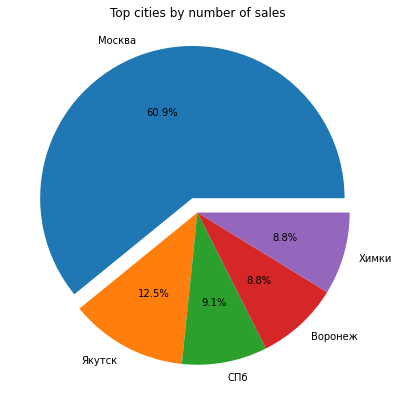

In [29]:
plt.figure(figsize=(7, 7))
plt.pie(df['city'].value_counts().head(), labels = list(df['city'].value_counts().head().index), 
        autopct='%1.1f%%', explode = [0.1, 0, 0, 0, 0])
plt.title('Top cities by number of sales')
plt.show()

### Item name

Find top-10 items.

In [30]:
df['item_name'].value_counts().head(10)

Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    31340
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            9408
Прием денежных средств для 1С-Онлайн                                                      9067
Diablo III [PC, Jewel, русская версия]                                                    7479
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     6853
World of Warcraft. Карта оплаты игрового времени (online) (рус.в.) (60 дней) (Jewel)      6602
Grand Theft Auto V [PS3, русские субтитры]                                                6475
Call of Duty: Black Ops II [PС, Jewel, русская версия]                                    6320
Minecraft [Xbox 360, английская версия]                                                   5811
Grand Theft Auto V [Xbox 360, русские субтитры]                                           5805
Name: item_name, dtype: int64

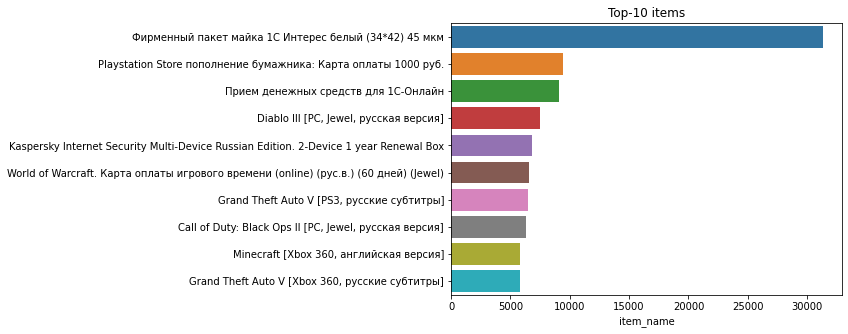

In [31]:
plt.figure(figsize=(7, 5))
sns.barplot(y = df['item_name'].value_counts().head(10).index, x = df['item_name'].value_counts().head(10))
plt.title('Top-10 items')
plt.show()

### Item category

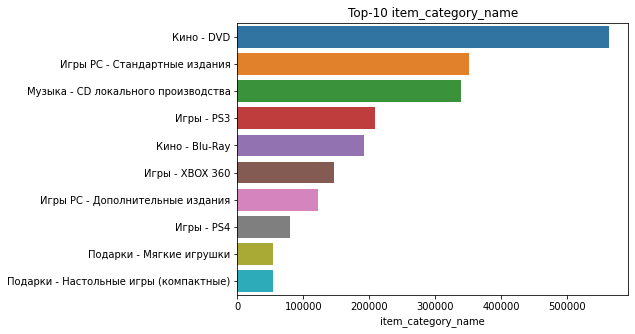

In [32]:
plt.figure(figsize=(7, 5))
sns.barplot(y = df['item_category_name'].value_counts().head(10).index, x = df['item_category_name'].value_counts().head(10))
plt.title('Top-10 item_category_name')
plt.show()

The most popular category is Кино - DVD.

### Sales volume by years

In [33]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month

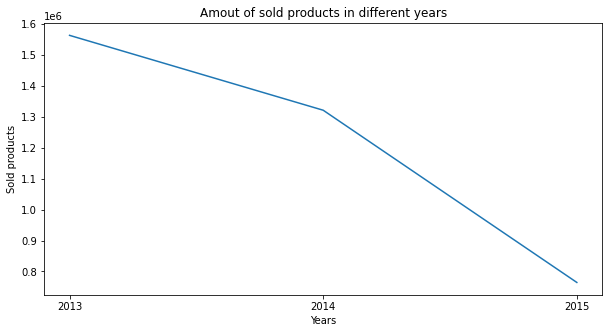

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(df.groupby(pd.DatetimeIndex(df['date']).year)['item_cnt_day'].sum())
plt.xlabel('Years')
plt.xticks(df.groupby(pd.DatetimeIndex(df['date']).year)['item_cnt_day'].sum().index)
plt.ylabel('Sold products')
plt.title('Amout of sold products in different years')
plt.show()

Between 2013 and 2015 sales fell.

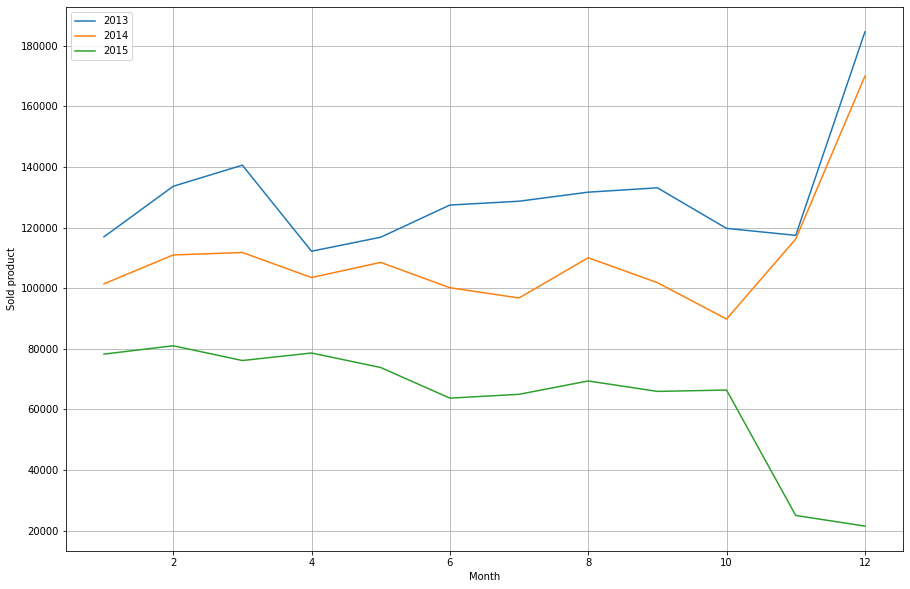

In [35]:
year_2013 = df.groupby(['year', 'month'])['item_cnt_day'].sum().reset_index().query('year == 2013')
year_2014 = df.groupby(['year', 'month'])['item_cnt_day'].sum().reset_index().query('year == 2014')
year_2015 = df.groupby(['year', 'month'])['item_cnt_day'].sum().reset_index().query('year == 2015')

plt.figure(figsize=(15, 10))
plt.title('')
plt.plot(year_2013['month'], year_2013['item_cnt_day'], label="2013")
plt.plot(year_2014['month'], year_2014['item_cnt_day'], label="2014")
plt.plot(year_2015['month'], year_2015['item_cnt_day'], label="2015")
plt.xlabel('Month')
plt.ylabel('Sold product')
plt.legend()
plt.grid(True)

In December 2013 and 2014 there is a strong increase in sales in contrast to 2015.

### Sales volume by month

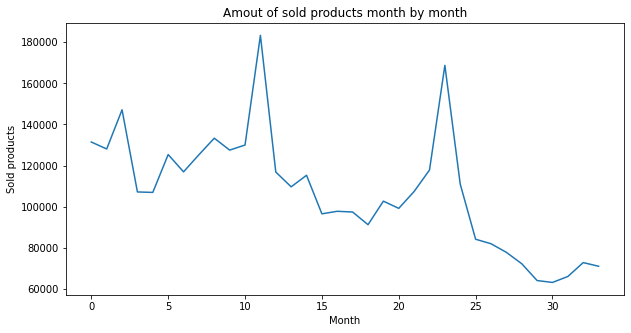

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(df.groupby('date_block_num')['item_cnt_day'].sum())
plt.xlabel('Month')
plt.ylabel('Sold products')
plt.title('Amout of sold products month by month')
plt.show()

Sales are gradually declining, with only outbreaks in December 2013 and 2014.

## Prepare data for training

We need to predict sales by items and shop for a month, so we will create a pivot table that reflects the monthly sales volume.

In [37]:
df_train = train.pivot_table(index=['shop_id', 'item_id'], columns='date_block_num', values='item_cnt_day', aggfunc='sum').reset_index()

In [38]:
df_train = df_train.fillna(0)

In [39]:
df_train = df_train.merge(items, on='item_id', how='left')
df_train = df_train.merge(shops, on='shop_id', how='left')
df_train = df_train.drop(['item_name'], axis=1)

Add cities.

In [40]:
df_train['city'] = df_train['shop_name'].apply(lambda x: " ".join(x.split()[:1]))
df_train['city'] = df_train['city'].replace('!Якутск', 'Якутск')
df_train['city'] = df_train['city'].replace('Цифровой', 'Интернет-магазин')
df_train = df_train.drop(['shop_name'], axis=1)

Encode the cities.

In [41]:
encoder = preprocessing.LabelEncoder()

In [42]:
df_train['city'] = encoder.fit_transform(df_train['city'])

Rearrange the columns.

In [43]:
df_train = df_train[['shop_id', 'item_id', 'item_category_id', 'city'] + list(range(34))]

In [44]:
df_train.head()

,shop_id,item_id,item_category_id,city,0,1,2,3,4,5,...,24,25,26,27,28,29,30,31,32,33
0,0,30,40,28,0.0,31.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,31,37,28,0.0,11.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,32,40,28,6.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,33,37,28,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,35,40,28,1.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Divide by X and y.

In [45]:
X = df_train.drop([33], axis=1)
y = df_train[33]

Create a function to add the results of the models.

In [46]:
results = {'name': [], 'best_params':[], 'RMSE':[]}

def add_model_result(results, name, best_params, rmse):
    results['name'].append(name)
    results['best_params'].append(best_params)
    results['RMSE'].append(rmse)

## Train model

### CatBoost

In [47]:
%%time
model = CatBoostRegressor(silent=True)

parameters = {'depth' : sp_randint(1, 20),
              'learning_rate' : [0.005, 0.01, 0.02, 0.03],
              'iterations' : sp_randint(300, 1500)
             }
grid = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=3)
grid.fit(X, y)

CPU times: user 1h 53min 59s, sys: 44.3 s, total: 1h 54min 43s
Wall time: 1h 2s


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f1f5a7a2310>,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1f5a7a2ad0>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1f5ad914d0>,
                                        'learning_rate': [0.005, 0.01, 0.02,
                                                          0.03]},
                   scoring='neg_mean_squared_error')

In [48]:
print('CatBoost', (abs(grid.best_score_))**0.5, grid.best_params_)

CatBoost 3.5435587367946635 {'depth': 1, 'iterations': 1383, 'learning_rate': 0.01}


In [49]:
add_model_result(results, 'CatBoost', grid.best_params_, (abs(grid.best_score_))**0.5)

### LightGBM 

In [50]:
%%time
model = lgb.LGBMRegressor()
parameters = {'num_leaves' : [20,40,60,80,100],
              'max_depth' : sp_randint(1, 10),
              'reg_alpha':[0,0.01,0.03]}

grid = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=3)
grid.fit(X, y)

CPU times: user 3min 5s, sys: 1.57 s, total: 3min 6s
Wall time: 1min 40s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1f5a79bcd0>,
                                        'num_leaves': [20, 40, 60, 80, 100],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   scoring='neg_mean_squared_error')

In [51]:
print('LightGBM', (abs(grid.best_score_))**0.5, grid.best_params_)

LightGBM 3.6526452570527685 {'max_depth': 3, 'num_leaves': 60, 'reg_alpha': 0.01}


In [52]:
add_model_result(results, 'LightGBM', grid.best_params_, (abs(grid.best_score_))**0.5)

### LSTM

In [53]:
X_train = np.expand_dims(df_train.drop([33], axis=1).values,axis=2)
y_train = df_train[33]

In [54]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(units = 64,input_shape = (37,1)))
LSTM_model.add(Dense(8,activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(1,activation='relu'))
hyper_opt = keras.optimizers.Adam()
LSTM_model.compile(loss = 'mean_squared_error',optimizer = hyper_opt, metrics = ['mean_squared_error'])
LSTM_model.fit(X_train, y_train, batch_size = 1024, epochs = 20, validation_split=0.4)

Epoch 1/20
249/249 [==============================] - 74s 285ms/step - loss: 24.4175 - mean_squared_error: 24.4175 - val_loss: 2.3457 - val_mean_squared_error: 2.3457
Epoch 2/20
249/249 [==============================] - 69s 277ms/step - loss: 24.1410 - mean_squared_error: 24.1410 - val_loss: 2.2970 - val_mean_squared_error: 2.2970
Epoch 3/20
249/249 [==============================] - 69s 277ms/step - loss: 24.0323 - mean_squared_error: 24.0323 - val_loss: 2.2121 - val_mean_squared_error: 2.2121
Epoch 4/20
249/249 [==============================] - 70s 281ms/step - loss: 23.8694 - mean_squared_error: 23.8694 - val_loss: 2.2011 - val_mean_squared_error: 2.2011
Epoch 5/20
249/249 [==============================] - 83s 334ms/step - loss: 23.7022 - mean_squared_error: 23.7022 - val_loss: 2.1152 - val_mean_squared_error: 2.1152
Epoch 6/20
249/249 [==============================] - 73s 292ms/step - loss: 23.7620 - mean_squared_error: 23.7620 - val_loss: 2.0747 - val_mean_squared_error: 2.074

In [55]:
add_model_result(results, 'LSTM', '', 1.7)

### Result

In [56]:
pd.DataFrame(results).sort_values('RMSE')


,name,best_params,RMSE
2,LSTM,,1.700000
0,CatBoost,"{'depth': 1, 'iterations': 1383, 'learning_rat...",3.543559
1,LightGBM,"{'max_depth': 3, 'num_leaves': 60, 'reg_alpha'...",3.652645


## Prepare data for testing

In [57]:
test = test.merge(df_train, on = ['item_id','shop_id'], how = 'left')

In [58]:
x_test = test.drop(['ID', 33], axis=1)
x_test.fillna(0,inplace = True)
x_test = np.expand_dims(x_test,axis = 2)

In [59]:
y_pred = LSTM_model.predict(x_test)

6694/6694 [==============================] - 56s 8ms/step


In [60]:
submission = pd.DataFrame({'ID':test['ID'],'item_cnt_month': y_pred.reshape(214200,)})
submission.to_csv('submission.csv',index=False)

### Conclusion

Top cities by number of sales:
1. Moscow (60.9%);
2. Yakutsk (12.5%);
3. Saint Petersburg (9.1%);
4. Voronezh (8.8%);
5. Khimki (8.8%).

The most popular items:
1. Фирменный пакет майка 1С Интерес белый;
2. Playstation Store пополнение бумажника: Карта оплаты 1000 руб.;
3. Прием денежных средств для 1С-Онлайн.

The most popular item categories:
1. Кино - DVD;
2. Игры PC - Стандартные издания;
3. Музыка - CD локального производства.

Between 2013 and 2015 sales fell. In December 2013 and 2014 there is a strong increase in sales in contrast to 2015.

The best nodel is LSTM.
